### Importing the needed libraries 

In [1]:
from cuqi.distribution import UserDefinedDistribution
from cuqi.testproblem import Poisson1D
from cuqi.problem import BayesianProblem
import cuqi
import inspect
import numpy as np
import matplotlib.pyplot as plt
from cuqi.sampler import MH, CWMH, ULA, MALA, NUTS

import time

import scipy.stats as sps
from scipy.stats import gaussian_kde
import pandas as pd
import cProfile, pstats, io
from pstats import SortKey
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import sys
# Change the current working directory to the root of the project
sys.path.append(os.path.abspath('..'))

# Now you should be able to import the module
from utilities import TableAutomization as TA



# The banana distribution


In [15]:


# logpdf = lambda x1, x2:  (- x1**2 +( np.sin(x2)**(-5) - x1)**2)/2


threshold = lambda x: max(np.abs(np.sin(x[1])),0.001) * (np.positive(np.sin(x[1]))*2 -1)
logpdf = lambda x:  (- x[0]**2 +( threshold**(-5) - x[0])**2)/2
gradient_x =  lambda x: np.array([- threshold**(-5),-5 * (threshold** (-5) - x[0]) *(threshold**(-6) * np.cos(x[1]))])

target_sixmodal = UserDefinedDistribution(dim=2, logpdf_func=logpdf, gradient_func=gradient_x)

In [26]:
gradient_x([1,1])

[-2.3703052192423173, -10.427717680175142]

### Plotting the "banana"

In [16]:
TA.plot_pdf_2D(target_sixmodal, -10, 10, -10, 10)

TypeError: unsupported operand type(s) for ** or pow(): 'function' and 'int'

## 1. First Example 


- Compute sampling methods with the followig parameters

1. __MH_fixed__ : scale = 0.05, Ns = 10000, Nb = 0
2. __MH_adapted__:  scale = 0.05, Ns = 8500, Nb = 1500
3.  __ULA__: scale = 0.065, Ns = 10000, Nb = 0
4.  __MALA__: scale = 0.065, Ns = 10000, Nb = 5000
5. __NUTS__: scale = 0.05, Ns = 1000, Nb = 100


In [3]:
df , (fig, axs) = TA.create_comparison(target_sixmodal, [0.05, 0.05, 0.065, 0.065, 0.05 ], [10000, 8500, 10000, 10000, 1000],[0, 1500, 0, 5000, 100], x0 = np.array([1, 1]), seed = 12)

Sample 10000 / 10000

Average acceptance rate: 0.0031 

Sample 10000 / 10000

Average acceptance rate: 0.00011764705882352942 MCMC scale: 0.014916055681339014 

Sample 10000 / 10000
Sample 15000 / 15000
Sample 1100 / 1100


/Users/naoki/Desktop/CUQIpy_project/CUQIpy-Benchmarks/utilities/TableAutomization.py:277: RuntimeWarning: overflow encountered in exp
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))
/var/folders/br/kqx4wrcd4yn6zmk5jlrz9r7c0000gn/T/ipykernel_58950/2590906891.py:2: RuntimeWarning: divide by zero encountered in scalar power
  logpdf = lambda x:  (- x[0]**2 +( np.sin(x[1])**(-5) - x[0])**2)/2
/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/matplotlib/colorbar.py:1098: RuntimeWarning: overflow encountered in add
  self._values = 0.5 * (self._boundaries[:-1] + self._boundaries[1:])
/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/matplotlib/ticker.py:2119: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/matplotlib/ticker.py:755: RuntimeWarning: overflow encountered in scalar power
  if abs_min // 10 ** oom != abs_max // 10 *

- Print table

In [4]:
TA.print_table(df)

+------------+---------+----------+-------+---------+---------+-------+--------+----------+
|   Method   | Samples | Burn-ins | Scale | ESS(v0) | ESS(v1) |   AR  | LogPDF | Gradient |
+------------+---------+----------+-------+---------+---------+-------+--------+----------+
|  MH_fixed  |  10000  |    0     |  0.05 |  2.322  |   2.54  | 0.003 | 10000  |    0     |
| MH_adapted |   8500  |   1500   |  0.05 |  3.738  |  3.738  |  0.0  | 10000  |    0     |
|    ULA     |  10000  |    0     | 0.065 |  1.295  |  51.686 |  1.0  | 10000  |  10000   |
|    MALA    |  10000  |   5000   | 0.065 |  13.265 |  7.528  |  0.02 | 15000  |  15000   |
|    NUTS    |   1000  |   100    |  0.05 |  3.247  |  1.711  | 0.017 |  3802  |   3802   |
+------------+---------+----------+-------+---------+---------+-------+--------+----------+


Observations:
- the conclusions are quite similar to the donut distributin: 
    - The MH_fixed is a bad sampling method in this: the sample are correlated 
    - the MH_adapted is still not great, however, one can see the improvement in the ESS value, also AR is lower, which might be due to adapting the scale to a higher one. 
    - Neither of these use gradient, thus the number of computed Gradients is 0
    - the ULA method shows a good ESS; an accceptence rate of 1.0, this is expected since ULA does not have the choice of declining a step
    - MALA improves upon ULA with a more balanced ESS but at the cost of increased computational complexity. 
    - NUTS: significantly outperforms other methods
- compared to donuts distribution, we can see that the NUTS sampling method has smaller comutational cost

- Now we will take a look at the samples of each method plotted onto the "banana" distribution graphs

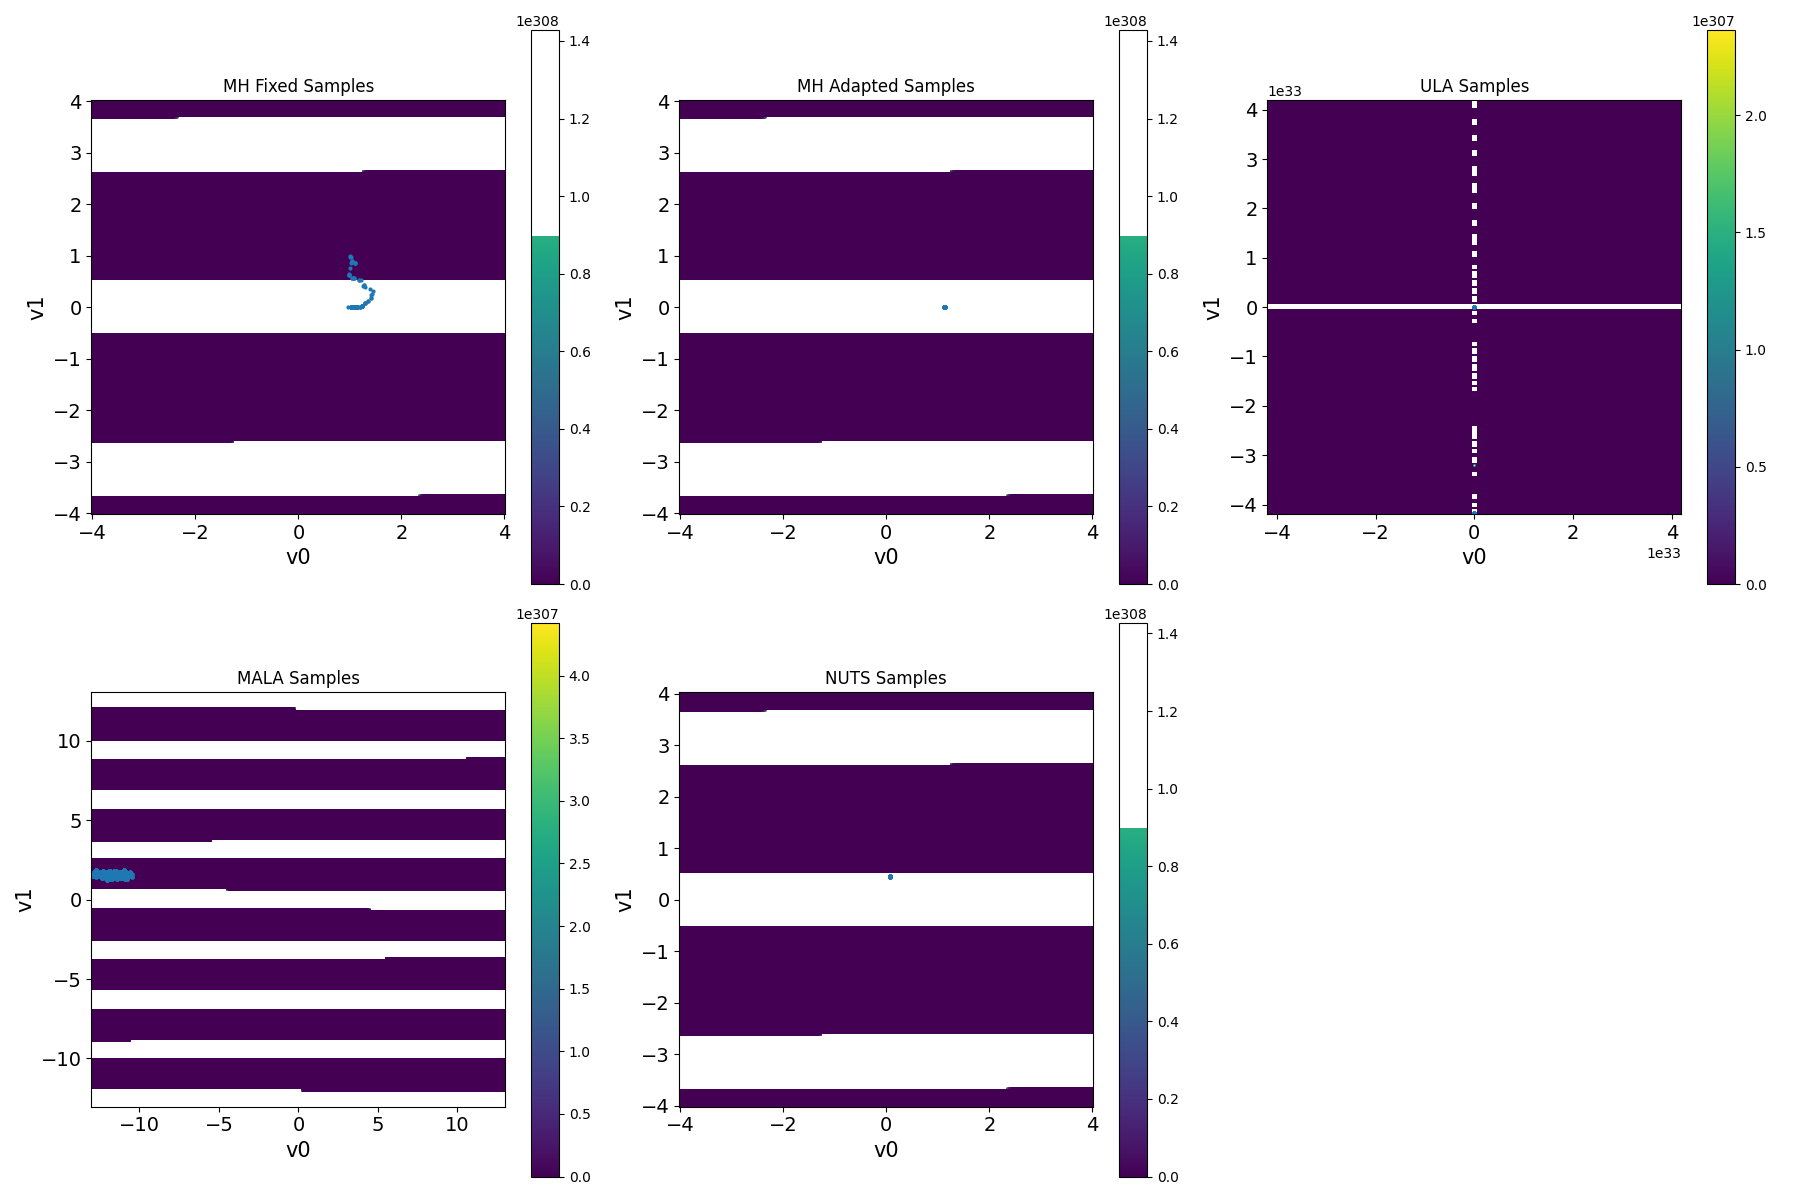

In [6]:
TA.show_plot(fig)

_Observations_:
- From the graphs, the results from the table can be seen more clearly seen
- as expected the MH_fixed does not stray far away from the initial point 
- both MALA and NUTS provide quite an accurate sample representation 

## 2. Second example
In this example, we sample x0 from an initial dstribution, and we use the sam enumber of samples, burnins and the same scale for each method: 
- scale = 0.05
- Ns = 8500
- Nb = 1500

- Compute sampling methods

In [7]:
true_mu = np.array([0, 0])
true_sigma = np.array([1,1])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

In [8]:
df, (fig, axs) = TA.create_comparison(target_sixmodal, 0.05, 8500, 1500, x0 = y, seed = 12,chains=2)

Sample 10000 / 10000

Average acceptance rate: 0.00011764705882352942 

Sample 10000 / 10000

Average acceptance rate: 0.00023529411764705883 MCMC scale: 0.014803773830255641 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000


/Users/naoki/Desktop/CUQIpy_project/CUQIpy-Benchmarks/utilities/TableAutomization.py:277: RuntimeWarning: overflow encountered in exp
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))
/var/folders/br/kqx4wrcd4yn6zmk5jlrz9r7c0000gn/T/ipykernel_58950/2590906891.py:2: RuntimeWarning: divide by zero encountered in scalar power
  logpdf = lambda x:  (- x[0]**2 +( np.sin(x[1])**(-5) - x[0])**2)/2
/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/matplotlib/colorbar.py:1098: RuntimeWarning: overflow encountered in add
  self._values = 0.5 * (self._boundaries[:-1] + self._boundaries[1:])
/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/matplotlib/ticker.py:2119: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/matplotlib/ticker.py:755: RuntimeWarning: overflow encountered in scalar power
  if abs_min // 10 ** oom != abs_max // 10 *

Sample 10000 / 10000

Average acceptance rate: 0.00011764705882352942 

Sample 10000 / 10000

Average acceptance rate: 0.00023529411764705883 MCMC scale: 0.014803773830255641 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000


/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


- Print table

In [9]:
TA.print_table(df)

+------------+---------+----------+-------+---------+---------+-------+----------+----------+--------+----------+
|   Method   | Samples | Burn-ins | Scale | ESS(v0) | ESS(v1) |   AR  | Rhat(v0) | Rhat(v1) | LogPDF | Gradient |
+------------+---------+----------+-------+---------+---------+-------+----------+----------+--------+----------+
|  MH_fixed  |   8500  |   1500   |  0.05 |  3.738  |  3.738  |  0.0  |  1.133   |  1.133   | 10000  |    0     |
| MH_adapted |   8500  |   1500   |  0.05 |  20.507 |  20.507 |  0.0  |  1.129   |  1.128   | 10000  |    0     |
|    ULA     |   8500  |   1500   |  0.05 |  1.295  |  8500.0 |  1.0  |  1.826   |    -     | 10000  |  10000   |
|    MALA    |   8500  |   1500   |  0.05 |  8500.0 |  8500.0 |  0.0  |    -     |    -     | 10000  |  10000   |
|    NUTS    |   8500  |   1500   |  0.05 |  2.288  |  1.285  | 0.029 |  1.323   |  1.851   | 39013  |  39013   |
+------------+---------+----------+-------+---------+---------+-------+----------+------

Observations:
- the  MH_fixed performs quite poorly, as ESS is very low, RHat strays from 1 and the AR is too high
- however, unlike in the donut distribution, the MH_adapted, performs better than expected, with Rhat close to 1.0 (converges well) and ESS, especially ESS(v1), is quite high 
- ULA has acceptence rate AR=1.0, as expected, and it performs well, with ESS parameters not too high but higher than MH, also R_hat is close to 1, meaing that it converges well enough
- MALA performs decently, but NUTS outperforms all the methods, but the computational costs are at least 4 times higher

- Create distribution images  

/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/matplotlib/image.py:463: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
/Users/naoki/miniconda3/envs/cuqipy/lib/python3.12/site-packages/matplotlib/image.py:468: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


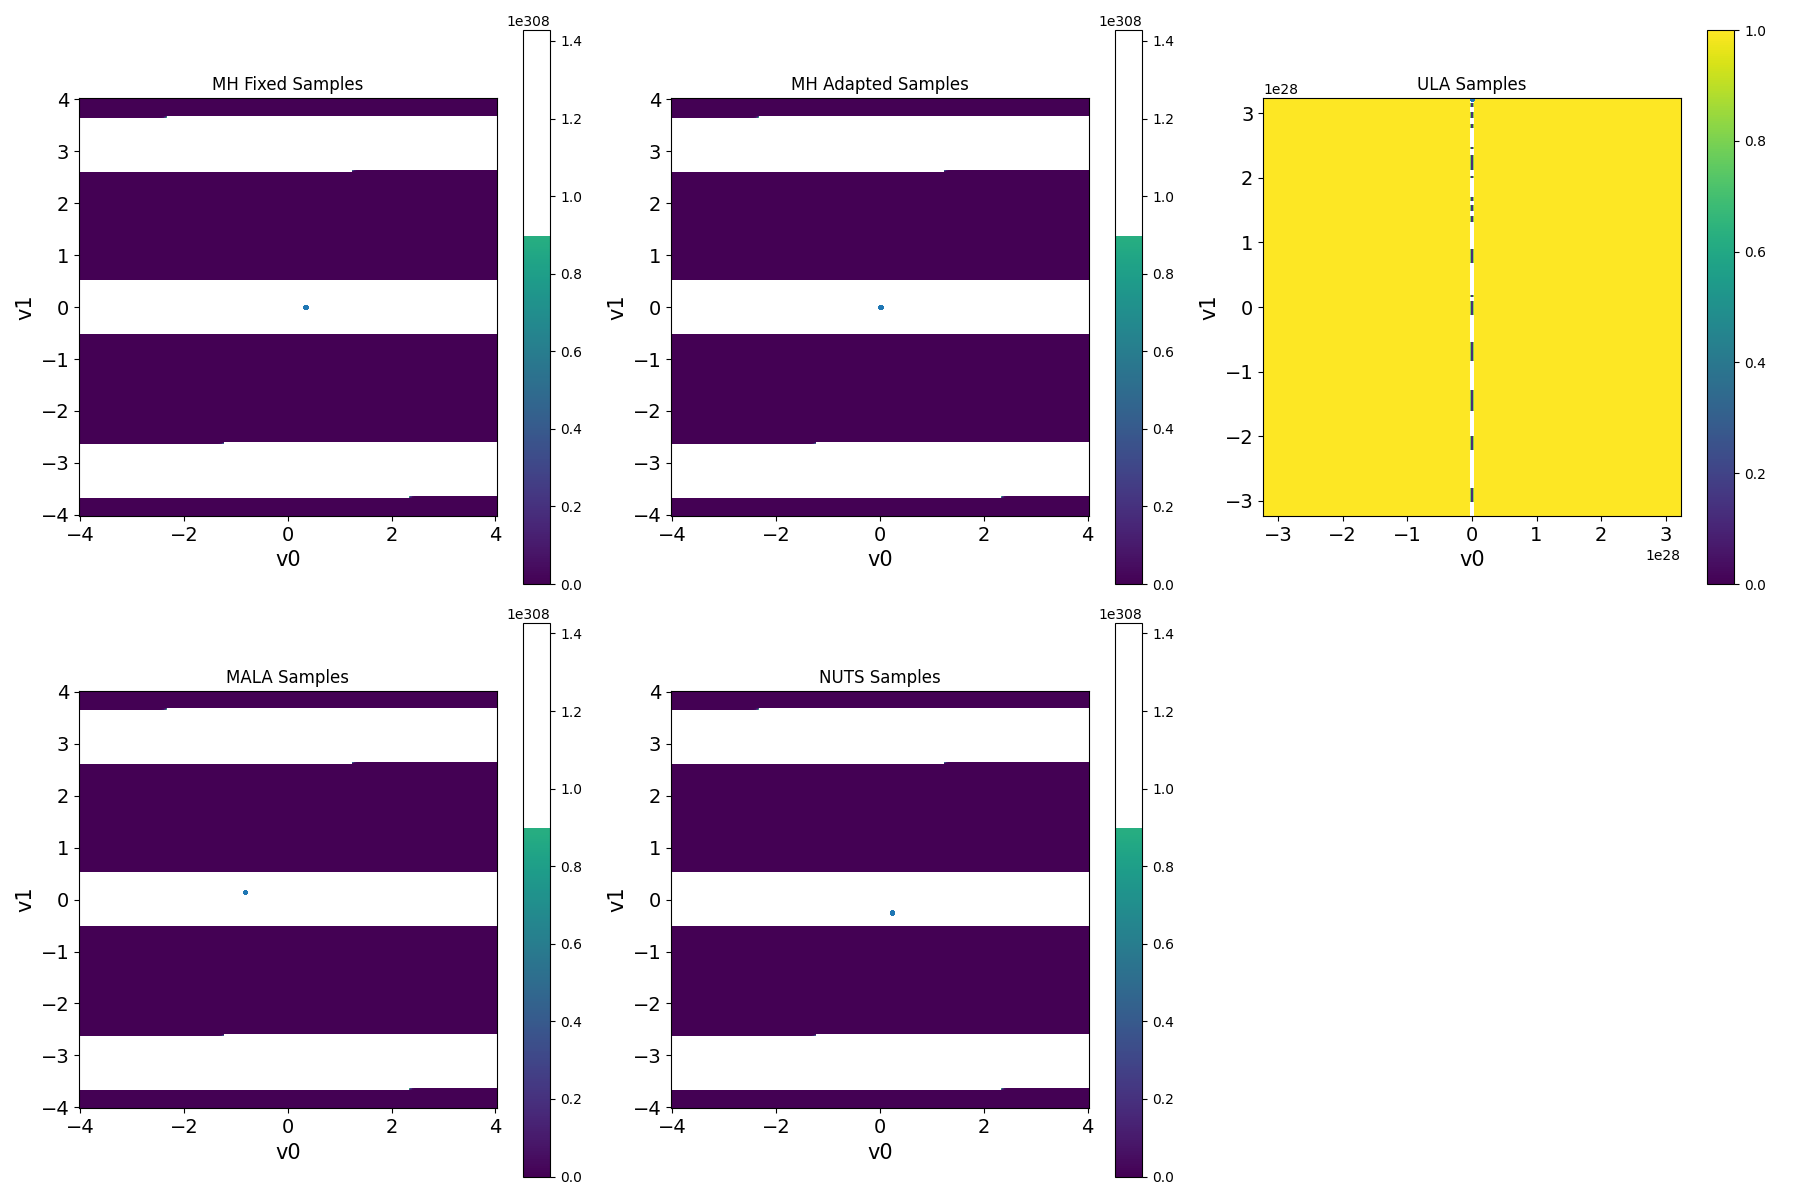

In [10]:
TA.show_plot(fig)

_Observations_
- as expected the MH_fixed stays quite close to the initial point  
- compared to the previous graphss,it can be seen that setting a relatively high number of burn ins will lead to better results 